In [1]:
import pandas as pd
import re
import numpy as np
import datetime
import sys
import string
import pickle
import datetime
from google.colab import output


In [2]:
from google.colab import drive
drive.mount('/gdrive')

colabs_dir = "/gdrive/MyDrive/Forecasting - DSI Capstone Spring '21/Colabs/"

Mounted at /gdrive


In [3]:
# https://www.kaggle.com/chrisrichardmiles/m5u-wsplevaluator-weighted-scaled-pinball-loss

def SPL_u(historical_data, horizon_data, u, h = 28):
    """Returns the scaled pinball loss for each series"""
    actuals = horizon_data['actual_sales']
    preds = horizon_data[str(u)]

    numerator = np.where(actuals >= preds, (actuals - preds) * u, (preds - actuals) * (1 - u)).sum()
    
    n = historical_data.shape[0]
    denominator = (1/(n-1))*sum([np.abs(historical_data[i]-historical_data[i-1]) for i in range(1, n)])
    # Now calculate the scaled pinball loss.  
    spl = (1/h)*(numerator/denominator)
    return spl

In [4]:
! ls "/gdrive/MyDrive/Forecasting - DSI Capstone Spring '21/Colabs/predictions/"

lgbm_store_product_quantiles.csv
lgbm_store_quantiles.csv
nbeats_product_test.csv
nbeats_product_test_FOODS_3_586.csv
nbeats_product_test_HOUSEHOLD_2_175.csv
nbeats_product_test_HOUSEHOLD_2_266.csv
nbeats_product_validation.csv
nbeats_product_validation_FOODS_3_586.csv
nbeats_product_validation_HOUSEHOLD_2_175.csv
nbeats_product_validation_HOUSEHOLD_2_266.csv
nbeats_store.csv
nbeats_store_product_quantiles.csv
nbeats_store_quantiles.csv
nbeats_store_salesonly.csv
nbeats_store_test.csv
nbeats_store_validation.csv
nonrec_lgbm_store_prediction.csv
nonrec_lgbm_store_product_prediction.csv
nonrec_lgbm_store_product_prediction_foods_3_586.csv
nonrec_lgbm_store_product_prediction_household_2_175.csv
nonrec_lgbm_store_product_prediction_household_2_266.csv
seq2seq_FOODS_3_586.csv
seq2seq_HOUSEHOLD_2_175.csv
seq2seq_HOUSEHOLD_2_266.csv
seq2seq_store.csv
seq2seq_store_product.csv
seq2seq_store_product_quantiles.csv
seq2seq_store_quantiles.csv
spl_results_2021-04-01.pkl


### Data

In [5]:
files_dict = {
    'seq2seq':{
        'store':{
            'preds':'predictions/seq2seq_store.csv',
            'quantiles':'predictions/seq2seq_store_quantiles.csv'
        },
        'store_product':{
            'preds':'predictions/seq2seq_store_product.csv',
            'quantiles':'predictions/seq2seq_store_product_quantiles.csv'
        }
    },
    'lgbm':{
        'store':{
            'preds':'predictions/nonrec_lgbm_store_prediction.csv',
            'quantiles':'predictions/lgbm_store_quantiles.csv'
        },
        'store_product':{
            'preds':'predictions/nonrec_lgbm_store_product_prediction.csv',
            'quantiles':'predictions/lgbm_store_product_quantiles.csv'
        }   
    },
    'nbeats':{
        'store':{
            'preds':'predictions/nbeats_store.csv',
            'quantiles':'predictions/nbeats_store_quantiles.csv'
        },
        'store_product':{
            'preds':'predictions/nbeats_product_test.csv',
            'quantiles':'predictions/nbeats_store_product_quantiles.csv'
        }   
    }

}

In [6]:
original_validation = pd.read_csv(colabs_dir+'data/sales_train_validation_ca1.csv')
original_evaluation = pd.read_csv(colabs_dir+'data/sales_train_evaluation_ca1.csv')
validation_store_sales = original_validation.loc[:, 'd_1069':'d_1798'].sum(axis=0)
evaluation_store_sales = original_evaluation.loc[:, 'd_1799':'d_1826'].sum(axis=0)
validation_store_product_sales = original_validation.loc[:, 'd_1069':'d_1798']
validation_store_product_sales['item_id'] = original_validation['item_id']
evaluation_store_product_sales = original_evaluation.loc[:, 'd_1799':'d_1826']
evaluation_store_product_sales['item_id'] = original_evaluation['item_id']
prices = pd.read_csv(colabs_dir+'data/sell_prices_ca1.csv')
calendar = pd.read_csv(colabs_dir+'data/calendar.csv')

In [ ]:
# Create weights data frame: total revenue of a product over the 
# last 28 days of the training period

val_m = pd.melt(
    validation_store_product_sales,
    id_vars = 'item_id',
    var_name = 'd',
    value_name = 'sales')

last_28_days = ['d_'+str(1771+i) for i in range(28)]

val_m.loc[val_m.d.isin(last_28_days)]

weights_df = pd.merge(
    left = val_m,
    right = calendar[['d','wm_yr_wk']],
    on = 'd'
)
weights_df = pd.merge(right = weights_df, 
                      left = prices[['item_id','wm_yr_wk','sell_price']],
                      on = ['item_id','wm_yr_wk'])
weights_df['daily_item_revenue'] = weights_df['sell_price'] * weights_df['sales']
weights_df = weights_df.groupby('item_id')['daily_item_revenue'].sum().reset_index()
weights_df.rename(columns={'daily_item_revenue':'weight'}, inplace=True)

store_product_weights = weights_df.copy()
store_weights = weights_df['weight'].sum()

print(store_product_weights)
print(store_weights)

              item_id    weight
0         FOODS_1_001   1113.28
1         FOODS_1_002   2748.96
2         FOODS_1_003   1604.13
3         FOODS_1_004  16278.28
4         FOODS_1_005   2075.28
...               ...       ...
3042  HOUSEHOLD_2_512   1913.54
3043  HOUSEHOLD_2_513   2085.00
3044  HOUSEHOLD_2_514   3657.04
3045  HOUSEHOLD_2_515    226.55
3046  HOUSEHOLD_2_516    926.64

[3047 rows x 2 columns]
9703853.71


### Calculate SPL

In [ ]:
q = [0.01, 0.05, 0.165, 0.25, 0.5, 0.75, 0.835, 0.95, 0.99]

In [ ]:
# Read in data
spl_results = {}
for model in [
            #   'lgbm',
              'seq2seq',
            #   'nbeats'
              ]:
    
    print(f'\nmodel: {model}')
    spl_model = {}
    for level in ['store',
                  'store_product'
                  ]:
        print(f' level: {level}')
        preds_fn = files_dict[model][level]['preds']
        preds = pd.read_csv(colabs_dir+preds_fn)
        if 'predicted_sales' in preds.columns:
            preds.rename(columns = {"predicted_sales":"pred_sales"}, inplace=True)
        if 'sales' in preds.columns:
            preds.rename(columns = {"sales":"pred_sales"}, inplace=True)
        
        quantiles_fn = files_dict[model][level]['quantiles']
        quantiles = pd.read_csv(colabs_dir+quantiles_fn)
        
        if model == 'seq2seq':
            quantiles['d'] = ['d_'+str(1799+d) for d in range(28)]

        if level == 'store':
            df = pd.concat([preds, quantiles], axis=1)
            df.fillna(method='ffill', inplace=True)
            df['actual_sales'] = evaluation_store_sales.values

            # Replace the quantile residual with the predicted sales minus that residual
            for i in q:
                # df[str(i)] = df[str(i)] + df['pred_sales']
                df[str(i)] = df['pred_sales'] - df[str(i)]
            u_vals = {}
            for u in q:
                spl_u = SPL_u(
                    historical_data=validation_store_sales,
                    horizon_data = df,
                    u = u
                )
                u_vals[str(u)] = [spl_u]
            store_u_vals = pd.DataFrame.from_dict(data=u_vals, orient='columns')
            store_u_vals['model'] = model
            store_u_vals['level'] = level
            spl_model[level] = store_u_vals
            
        
        elif level == 'store_product':
            # HOBBIES_1_001
            # Merge quantiles on date
            evaluation_store_product_sales_m = pd.melt(
                evaluation_store_product_sales, id_vars=['item_id'],
                var_name='d', value_name='sales'
                )
            if model == 'seq2seq':
                df = pd.merge(left = preds, right = quantiles, on = 'd')
                df = pd.merge(left = df, right = evaluation_store_product_sales_m,
                                on=['item_id','d'])
                df.rename(columns={'sales':'actual_sales'}, inplace=True)
            else:
                df = pd.concat([preds, quantiles], 1)
                df.fillna(method='ffill', inplace=True)
                df = pd.merge(left = df, right = evaluation_store_product_sales_m,
                                on=['item_id'])
                df.rename(columns={'sales':'actual_sales'}, inplace=True)
            u_vals_l = []

            for idx, id in enumerate(np.unique(preds.item_id)):
                # if (idx+1) % 25 == 0 or idx+1 == len(np.unique(preds.item_id)):
                progress = '\r{}/{}'.format(str((idx+1)).rjust(7, ' '), len(np.unique(preds.item_id)))
                sys.stdout.write(progress)
                sys.stdout.flush()
                df_i = df.loc[df.item_id == id].reset_index()
                
                # Replace the quantile residual with the predicted sales minus that residual
                for i in q:
                    df_i[str(i)] = df_i[str(i)] + df_i['pred_sales']
                
                u_vals = {}
                
                historical_data=validation_store_product_sales.loc[
                    validation_store_product_sales.item_id == id, 'd_1069':'d_1798'
                    ]
                
                historical_data_t=historical_data.transpose()
                historical_data_t.columns = ['sales']
                if historical_data_t['sales'].sum() == 0:
                    continue
                
                start_date = historical_data_t.loc[historical_data_t.sales > 0].index[0]
                
                historical_data = historical_data.loc[:, start_date:'d_1798'].values[0]
                
                # Skip products that don't have at least two days of non-zero
                # sales in the training set
                if len(historical_data) < 2:
                    continue

                for u in q:
                    spl_u = SPL_u(
                        historical_data=historical_data,
                        horizon_data = df_i,
                        u = u
                    )
                    u_vals[str(u)] = [spl_u]
                u_vals = pd.DataFrame.from_dict(data=u_vals, orient='columns')
                u_vals['model'] = model
                u_vals['level'] = level
                u_vals['item_id'] = id
                u_vals_l.append(u_vals)
            store_product_u_vals = pd.concat(u_vals_l)
            spl_model[level] = store_product_u_vals
        
    spl_results[model] = spl_model

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

from google.colab import files
run_day = datetime.datetime.now().strftime('%Y-%m-%d')
fn = f"spl_results_{run_day}.pkl"
pickle.dump(spl_results, open( fn, "wb" ))
files.download(fn) 


model: seq2seq
 level: store
 level: store_product
    225/3049

KeyboardInterrupt: ignored

### Calculate WSPL

In [ ]:
use_previous_results = True
if use_previous_results:
    spl_results = pickle.load(
        open(colabs_dir+'predictions/spl_results_2021-04-01.pkl', "rb" ) 
        )

In [ ]:
# https://github.com/Mcompetitions/M5-methods/blob/58496eb5a5d7d7b8b81203f27eb4bcfc4c8cb682/Code%20of%20Winning%20Methods/U1/replication/quantiles_sage_1to9_eval.py#L2440

wspl_df_l = []

for m in spl_results.keys():
    store_spl = spl_results[m]['store']
    store_spl['item_id'] = 'CA_1'
    store_product_spl = spl_results[m]['store_product']

    spl_cmbn = pd.concat([store_spl[['item_id','0.01','0.05','0.165','0.25',
                                     '0.5','0.75','0.835','0.95','0.99']],
                          store_product_spl[['item_id','0.01','0.05','0.165','0.25',
                                             '0.5','0.75','0.835','0.95','0.99']]])
    
    # Filter weights just on the products that were scored by the models
    weights_m = weights_df.loc[weights_df.item_id.isin(store_product_spl.item_id)]

    weights_cmbn = pd.concat([weights_m,
                              pd.DataFrame(dict(
                                  item_id = 'CA_1',
                                  weight = weights_m['weight'].sum()), 
                                  index=[0])])

    spl_df = pd.merge(left = weights_cmbn, right = spl_cmbn, on='item_id')

    loss = spl_df['weight'].values*(spl_df.loc[:, '0.01':'0.99'].values.sum(axis=1))

    K = 2 # (2 levels, store and store-product)
    overall_wspl = (1/spl_df['weight'].sum()) * \
                    (1/K) * \
                    spl_df['weight'] * \
                    spl_df[['0.01','0.05','0.165','0.25',
                            '0.5','0.75','0.835','0.95','0.99']].mean(1)
    store_wspl = overall_wspl.values[-1]
    store_product_wspl = overall_wspl.values[:-1].sum()
    overall_wspl_total = overall_wspl.sum()

    wspl_df_i = pd.DataFrame(dict(
        model = [m],
        store_wspl = [store_wspl],
        store_product_wspl = [store_product_wspl],
        overall_wspl_total = [overall_wspl_total]
    ))
    
    wspl_df_l.append(wspl_df_i)
    
    # Calculate the weights for the store and k store-product levels
    # ($sales_i / sum($sales_1 : $sales_k)) * (1/k)
    # weights_store = weights_m['weight'].sum()/2 #weights_m.shape[0]
    # weights_store_product = (weights_m['weight']/weights_store)/2 #weights_m.shape[0]

    # store_wspl = np.mean((2*np.array(weights_store)) * store_spl.loc[:, '0.01':'0.99'].values)/np.mean((2*np.array(weights_store)))
    # store_wspl = weights_store * np.mean(store_spl, axis=1).values[0]
    
    # store_product_wspl = np.mean(np.matmul((2*weights_store_product.values),
                                #    store_product_spl.loc[:, '0.01':'0.99'].values))/np.mean((2*np.array(weights_store)))

    

    # store_product_wspl = np.matmul(weights_store_product.values,
    #                                np.mean(store_product_spl, axis=1).values)
    print(f'{m} store_wspl: {store_wspl}')
    print(f'{m} store product wspl: {store_product_wspl}')
    print(f'{m} overall wspl: {overall_wspl_total}')
    # TODO put this into a dataframe

wspl_df = pd.concat(wspl_df_l)

wspl_df.to_csv("wspd_df.csv", index=False)
wspl_df

lgbm store_wspl: 0.2112537939097871
lgbm store product wspl: 2.3735073616503044
lgbm overall wspl: 2.5847611555600913
seq2seq store_wspl: 0.2894675669277614
seq2seq store product wspl: 0.08577259294616396
seq2seq overall wspl: 0.37524015987392534
nbeats store_wspl: 0.2709922209695509
nbeats store product wspl: 1.913057609654413
nbeats overall wspl: 2.184049830623964


,model,store_wspl,store_product_wspl,overall_wspl_total
0,lgbm,0.211254,2.373507,2.584761
0,seq2seq,0.289468,0.085773,0.375240
0,nbeats,0.270992,1.913058,2.184050


### Plots

In [ ]:
# Create quantile predictions data frames for plotting

q = [0.01, 0.05, 0.165, 0.25, 0.5, 0.75, 0.835, 0.95, 0.99]
quanitles_predictions = {}

for model in [
              'lgbm',
              'seq2seq',
              'nbeats'
              ]:
    
    print(f'model: {model}')
    
    preds_fn = files_dict[model]['store']['preds']
    preds = pd.read_csv(colabs_dir+preds_fn)
    if 'predicted_sales' in preds.columns:
        preds.rename(columns = {"predicted_sales":"pred_sales"}, inplace=True)
    if 'sales' in preds.columns:
        preds.rename(columns = {"sales":"pred_sales"}, inplace=True)
    
    quantiles_fn = files_dict[model]['store']['quantiles']
    quantiles = pd.read_csv(colabs_dir+quantiles_fn)
    
    if model == 'seq2seq':
        quantiles['d'] = ['d_'+str(1799+d) for d in range(28)]

    df = pd.concat([preds, quantiles], axis=1)
    df.fillna(method='ffill', inplace=True)
    df['actual_sales'] = evaluation_store_sales.values
    for i in q:
        df[str(i)] = df['pred_sales'] - df[str(i)]
        # df[str(i)] = df[str(i)] + df['pred_sales']

    quanitles_predictions[model] = df
        

model: lgbm
model: seq2seq
model: nbeats


NameError: ignored

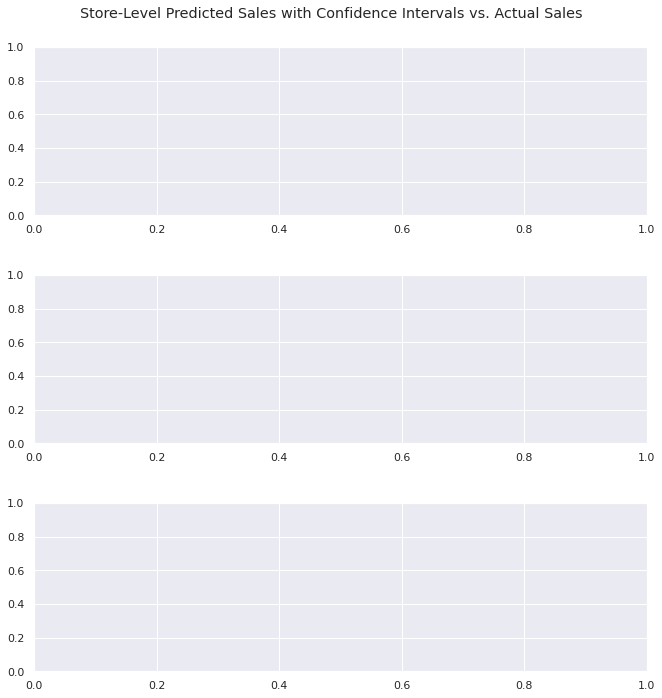

In [39]:
# Plot actual sales, predicted sales, and confidence intervals
tick_idxs = [0,7,14,21,28]
dates=[datetime.datetime.strptime('1/1/2016', "%m/%d/%Y")+datetime.timedelta(i) for i in tick_idxs]
dates = [i.strftime('%Y-%m-%d') for i in dates]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="colorblind")

fig, ax = plt.subplots(3,1,figsize=(10,10), sharey=True)
sns.set_theme(style="darkgrid", palette="colorblind")
fig.tight_layout(pad=3)
fig.suptitle("Store-Level Predicted Sales with Confidence Intervals vs. Actual Sales",
             y=1)

colors = dict(
    nbeats = 'C1',
    lgbm = 'C2',
    seq2seq = 'C3'
)

model_labels = dict(
    nbeats = 'nbeats',
    lgbm = 'LGBM',
    seq2seq = 'seq2seq'
)

for idx, k in enumerate(['lgbm',
                         'nbeats',
                         'seq2seq'
                         ]):
    df = quanitles_predictions[k]

    ax[idx].plot(df['actual_sales'], label = 'Actuals', c='C0')
    
    ax[idx].plot(df['pred_sales'], label = model_labels[k], c = colors[k])
    ax[idx].fill_between([i for i in range(28)], 
                    df['0.165'], 
                    df['0.835'], 
                    alpha=0.2, 
                    label = '68% CI')
    ax[idx].fill_between([i for i in range(28)], 
                    df['0.05'], 
                    df['0.95'], 
                    alpha=0.2,
                    label = '95% CI')
    ax[idx].fill_between([i for i in range(28)], 
                    df['0.01'], 
                    df['0.99'], 
                    alpha=0.2,
                    label = '99% CI')
    ax[idx].set_xticks(ticks=tick_idxs)
    ax[idx].set_xticklabels(labels=dates)

    ax[idx].set_title(model_labels[k])
    ax[idx].legend(loc = 'upper left')
    ax[idx].set_ylabel("Sales")
    ax[idx].set_xlabel("Date")
;



### Quantile Ranges Output

In [88]:
df_l = []
for m in ['lgbm','nbeats','seq2seq']:
    for l in ['store','store_product']:
        df = pd.read_csv(colabs_dir+files_dict[m][l]['quantiles'])
        if m == 'seq2seq':
            df = df.mean(axis=0)
            df = pd.DataFrame(df).transpose()
        df['model'] = m
        df['level'] = l
        df = df[['model','level',
                 '0.01','0.05','0.165','0.25','0.5',
                 '0.75','0.835','0.95','0.99']]
        
        df_l.append(df)

q_df = pd.concat(df_l,0)
q_df.sort_values(['level','model'])

for c in q_df.columns[2:]:
    q_df[c] = np.round(q_df[c], 5)

q_df.to_csv("combined_quantiles_by_model.csv", index=False)

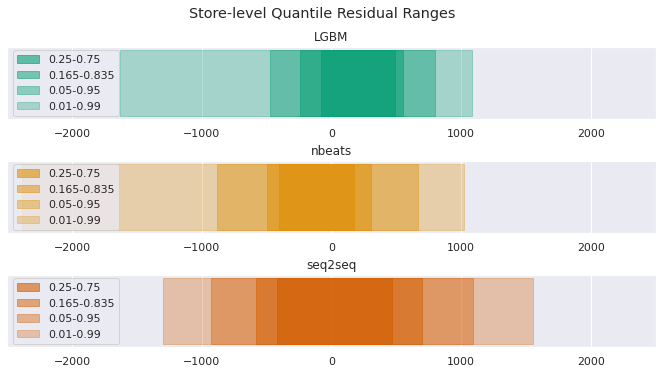

In [176]:
# Store-level Quantile Ranges

fig, ax = plt.subplots(3, 1, figsize=(10,5), 
                    #    sharex=True
                       )
sns.set_theme(style="darkgrid", palette="colorblind")
fig.tight_layout(pad=1.5)
fig.suptitle("Store-level Quantile Residual Ranges", y=1.05)

for idx, m in enumerate(['lgbm','nbeats','seq2seq']):
    q_df_m = q_df.loc[(q_df.model == m) & (q_df.level == 'store')]
    a = 0.6
    for p in [('0.25','0.75'),('0.165','0.835'),('0.05','0.95'),('0.01','0.99')]:
        ax[idx].fill_betweenx(y = [0, 1],
                            x1 = np.repeat(q_df_m[p[0]], 2),
                            x2 = np.repeat(q_df_m[p[1]], 2), 
                            alpha = a,
                            color = colors[m],
                            label = f'{p[0]}-{p[1]}')
        a = a - 0.1
    ax[idx].legend(loc = 'center left')
    ax[idx].set_title(model_labels[m])
    # ax[idx].set_xlabel('Residuals')
    ax[idx].set(xlim = (-2500,2500))
    ax[idx].axes.get_yaxis().set_visible(False)

plt.show()


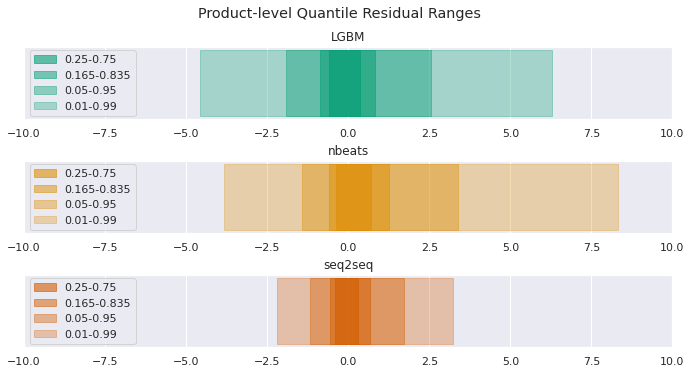

In [174]:
# Product-level Quantile Ranges

fig, ax = plt.subplots(3, 1, figsize=(10,5), 
                    #    sharex=True
                       )
sns.set_theme(style="darkgrid", palette="colorblind")
fig.tight_layout(pad=1.5)
fig.suptitle("Product-level Quantile Residual Ranges", y=1.05)

for idx, m in enumerate(['lgbm','nbeats','seq2seq']):
    q_df_m = q_df.loc[(q_df.model == m) & (q_df.level == 'store_product')]
    a = 0.6
    for p in [('0.25','0.75'),('0.165','0.835'),('0.05','0.95'),('0.01','0.99')]:
        ax[idx].fill_betweenx(y = [0, 1],
                            x1 = np.repeat(q_df_m[p[0]], 2),
                            x2 = np.repeat(q_df_m[p[1]], 2), 
                            alpha = a,
                            color = colors[m],
                            label = f'{p[0]}-{p[1]}')
        a = a - 0.1
    ax[idx].legend(loc = 'center left')
    ax[idx].set_title(model_labels[m])
    # ax[idx].set_xlabel('Residuals')
    ax[idx].set(xlim = (-10,10))
    ax[idx].axes.get_yaxis().set_visible(False)

plt.show()
